# Test tiger with location scale regression

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi

# Use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd

rng = np.random.default_rng(42)

## Simulate data

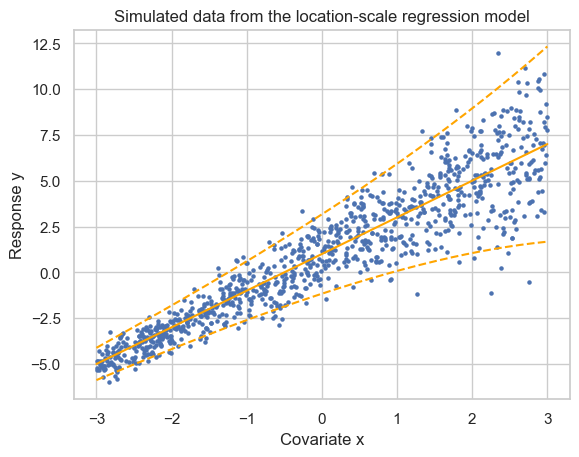

In [2]:
# Sample size and true parameters
n = 1000
true_beta = np.array([1.0, 2.0])
true_gamma = np.array([0.1, 0.3])

# Data-generating process
x0 = rng.uniform(size=n, low=-3, high=3)
X_mat = np.column_stack([np.ones(n), x0])
Z_mat = np.column_stack([np.ones(n), x0])
log_sigma = Z_mat @ true_gamma
sigma = np.exp(log_sigma)
eps = rng.normal(scale=sigma, size=n)
response_vec = X_mat @ true_beta + eps

# Data to plot the linear regression line
x_plot = np.linspace(-3, 3, num=200)
X_plot = np.column_stack([np.ones(200), x_plot])
Z_plot = np.column_stack([np.ones(200), x_plot])
mean_plot =  X_plot @ true_beta
sigma_plot = np.exp(Z_plot @ true_gamma)

# Set the seaborn theme
sns.set_theme(style="whitegrid")
# Plot the simulated data
plt.scatter(x0, response_vec, s = 5)
plt.plot(x_plot, mean_plot, color="orange")
plt.plot(x_plot, mean_plot - 1.96*sigma_plot, color="orange", linestyle="--")
plt.plot(x_plot, mean_plot + 1.96*sigma_plot, color="orange", linestyle="--")
plt.title("Simulated data from the location-scale regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up model in tigerpy

In [3]:
# Set up design matrix location
X = tiger.Obs(name = "X_loc")
X.fixed(data = x0)

# Set up design matrix scale
Z = tiger.Obs(name = "Z_scale")
Z.fixed(data = x0)

# Set up hyperparameters for the location
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters for the location
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# Set up hyperparameters for the scale
gamma_loc = tiger.Hyper(0.0, name="gamma_loc")
gamma_scale = tiger.Hyper(10.0, name="gamma_scale")

# Set up parameters for the scale
gamma_dist = tiger.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = tiger.Param(value=np.array([0.0, 0.0]), distribution=gamma_dist, name="gamma")

# Set up the linear predictors
lpred_loc = tiger.Lpred(obs=X, beta=beta)
lpred_scale = tiger.Lpred(obs=Z, function=jnp.exp, gamma=gamma)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred_loc, scale=lpred_scale)
m = tiger.Model(response=response_vec, distribution=response_dist)

In [4]:
jnp.sum(m.log_lik)

Array(-8436.268, dtype=float32)

In [5]:
m.log_prior

Array(-17.491264, dtype=float32)

In [6]:
m.log_prob

Array(-8453.759, dtype=float32)

In [7]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [8]:
graph.logprob()

Array(-8453.759, dtype=float32)

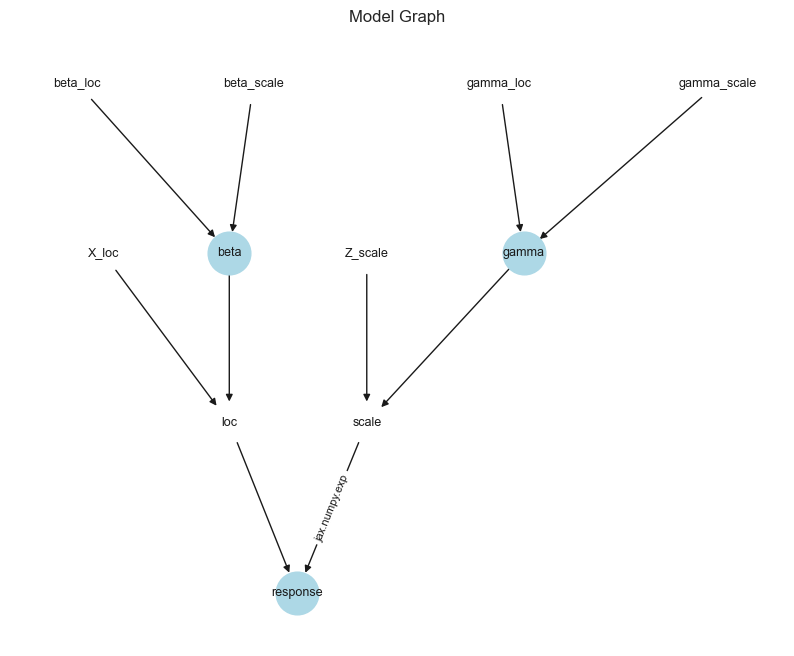

In [9]:
graph.visualize_graph()

## Test Location Scale regression improvements 

In [10]:
import tigerpy.distributions.mvn as mvn
from tigerpy.bbvi.transform import (
    log_cholesky_parametrization_to_tril
)
from tigerpy.bbvi.init_bbvi import (
    add_jitter
)

In [20]:
q = bbvi.Bbvi(graph=graph, 
              model_init=True, 
              loc_prec=10.0, 
              scale_prec=10.0)
key = jax.random.PRNGKey(27)
q.init_var_params

{'beta': {'loc': Array([0.9378593, 1.9952936], dtype=float32),
  'log_cholesky_prec': Array([2.3025851, 0.       , 2.3025851], dtype=float32, weak_type=True)},
 'gamma': {'loc': Array([0.11262584, 0.2886592 ], dtype=float32),
  'log_cholesky_prec': Array([2.3025851, 0.       , 2.3025851], dtype=float32, weak_type=True)}}

In [21]:
q.init_var_params

{'beta': {'loc': Array([0.9378593, 1.9952936], dtype=float32),
  'log_cholesky_prec': Array([2.3025851, 0.       , 2.3025851], dtype=float32, weak_type=True)},
 'gamma': {'loc': Array([0.11262584, 0.2886592 ], dtype=float32),
  'log_cholesky_prec': Array([2.3025851, 0.       , 2.3025851], dtype=float32, weak_type=True)}}

In [22]:
loc_beta, log_chol__prec_beta = q.init_var_params["beta"]["loc"], q.init_var_params["beta"]["log_cholesky_prec"]
loc_gamma, log_chol__prec_gamma = q.init_var_params["gamma"]["loc"], q.init_var_params["gamma"]["log_cholesky_prec"]
lower_tri_beta = log_cholesky_parametrization_to_tril(log_chol__prec_beta, d=loc_beta.shape[0])
lower_tri_gamma = log_cholesky_parametrization_to_tril(log_chol__prec_gamma, d=loc_gamma.shape[0])


In [23]:
samples_beta = mvn.mvn_precision_chol_sample(loc=loc_beta, precision_matrix_chol=lower_tri_beta, key=key, S=64)
samples_gamma = mvn.mvn_precision_chol_sample(loc=loc_gamma, precision_matrix_chol=lower_tri_gamma, key=key, S=64)


In [24]:
test_samples = {"beta": samples_beta, "gamma": samples_gamma}
batch_idx = jax.random.choice(key, n, (256,), replace=False)
data_new = jax.tree_map(lambda x: x[batch_idx], q.data)

In [25]:
q.mc_logprob(data_new, test_samples, q.num_obs)

Array(-1587.5327, dtype=float32)

In [26]:
q.lower_bound(q.init_var_params, 
              data_new,
              num_obs=q.num_obs,
              num_var_samples=64,
              key=key)

Array(1615.0767, dtype=float32)

## Inference with BBVI

In [37]:
q = bbvi.Bbvi(graph=graph, 
              model_init=True,
              loc_prec=10.0, 
              scale_prec=10.0)

In [38]:
q.run_bbvi(step_size=0.001,
           threshold=1e-2,
           key_int=27,
           batch_size=512,
           num_var_samples=64,
           chunk_size=50,
           epochs=500)

Start optimization ...
Finished optimization.


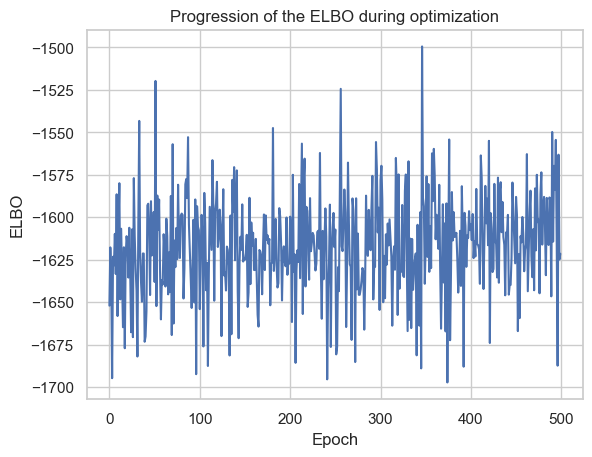

In [39]:
q.plot_elbo()

In [40]:
q.return_loc_params

{'beta': {'loc': Array([0.94560766, 2.0184338 ], dtype=float32)},
 'gamma': {'loc': Array([0.13402526, 0.27068603], dtype=float32)}}